# transversity-combined

In [1]:
import sys,os
os.chdir('../')
import itertools as it
import numpy as np
import pandas as pd
from scipy.special import beta
from scipy.integrate import quad
import pylab as py
from  matplotlib import rc
from matplotlib.colors import LogNorm
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)
import matplotlib
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tools.tools import save,load,lprint,load_config
from tools.bar import BAR
from resman import RESMAN
import nest
import obslib.moments.moments

## setup

In [2]:
class RUN:
    
    def __init__(self,path):
        fname=path.split('/')[-1]
        self.conf=load_config('%s/%s.py'%(path,fname))
        self.resman=RESMAN(self.conf);
        self.parman=self.resman.conf['parman']
        nest=load('%s/nest'%path)
        wmin_cut=1e-7
        self.weights=[nest['weights'][j] for j in range(len(nest['weights'])) if nest['weights'][j]>wmin_cut]
        self.samples=[nest['samples'][j] for j in range(len(nest['weights'])) if nest['weights'][j]>wmin_cut]
        self.weights/=np.sum(self.weights)
        self.moments=obslib.moments.moments.MOMENTS(self.conf)

In [3]:
run1=RUN('outputs/transversity')
run2=RUN('outputs/transversity2')

loading sidis data sets 4000
loading sidis data sets 4001
loading sidis data sets 4002
loading sidis data sets 4003
loading sidis data sets 4004
loading sidis data sets 4005
loading sidis data sets 4006
loading sidis data sets 4007
loading sidis data sets 4008
loading sidis data sets 4009
loading sidis data sets 4010
loading sidis data sets 4011
loading sidis data sets 3000
loading sidis data sets 3003
loading sidis data sets 3004
loading sidis data sets 3005
loading sidis data sets 3007
loading sidis data sets 3008
loading sidis data sets 3010
loading sidis data sets 3012
loading sidis data sets 3013
loading sidis data sets 3016
loading sidis data sets 3017
loading sidis data sets 3018
loading sidis data sets 3021
loading sidis data sets 3023
loading sidis data sets 3024
loading sidis data sets 3025
loading sidis data sets 3026
loading sidis data sets 3027
loading sidis data sets 4000
loading sidis data sets 4001
loading sidis data sets 4002
loading sidis data sets 4003
loading sidis 

In [4]:
def get_kinematics():
    tabs=run1.resman.sidisres.tabs
    X,Z,Q2,pT=[],[],[],[]
    for k in tabs:X=np.append(tabs[k]['x'],X)
    for k in tabs:Z=np.append(tabs[k]['z'],Z)
    for k in tabs:Q2=np.append(tabs[k]['Q2'],Q2)
    for k in tabs:pT=np.append(tabs[k]['pT'],pT)
    return {'X':X,'Z':Z,'Q2':Q2,'pT':pT}
kin=get_kinematics()

## parameters

In [5]:
def plot_params(k,kk):
    order=run1.parman.order
    get_idx=lambda _kk: [i for i in range(len(order)) if order[i][1]==k if order[i][2]==_kk][0]
    nrows,ncols=1,5
    py.figure(figsize=(ncols*3,nrows*2))
    for i in range(len(kk)):
        ax=py.subplot(nrows,ncols,i+1)
        par1=np.transpose(run1.samples)[get_idx(kk[i])]
        par2=np.transpose(run2.samples)[get_idx(kk[i])]
        ax.hist(par1,histtype='stepfilled',weights=run1.weights,bins=10,facecolor='Yellow',edgecolor='k')
        ax.hist(par2,histtype='stepfilled',weights=run2.weights,bins=10,facecolor='none',edgecolor='r',hatch='...')
        pmin=run1.conf['params'][k][kk[i]]['min']
        pmax=run1.conf['params'][k][kk[i]]['max']
        ax.set_xlim(pmin,pmax)
        ax.set_title('%s-%s'%(k,kk[i]))
    py.tight_layout()


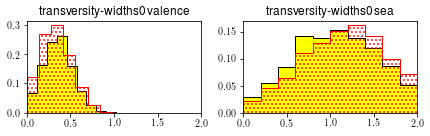

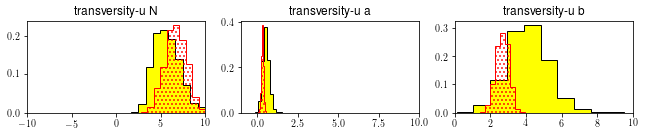

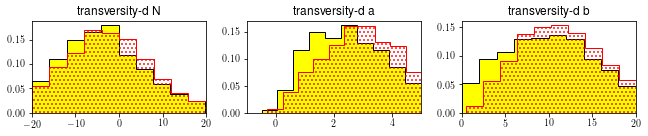

In [6]:
plot_params('transversity',['widths0 valence','widths0 sea'])
plot_params('transversity',['u N','u a','u b'])
plot_params('transversity',['d N','d a','d b'])

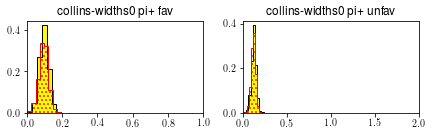

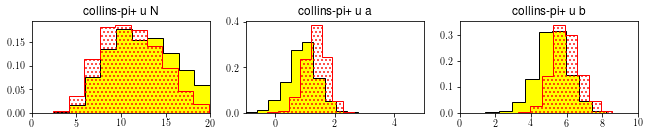

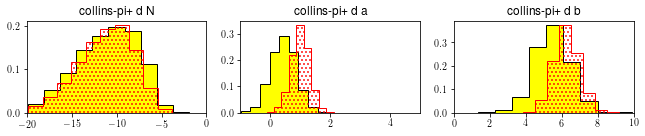

In [7]:
plot_params('collins',['widths0 pi+ fav','widths0 pi+ unfav'])
plot_params('collins',['pi+ u N','pi+ u a','pi+ u b'])
plot_params('collins',['pi+ d N','pi+ d a','pi+ d b'])

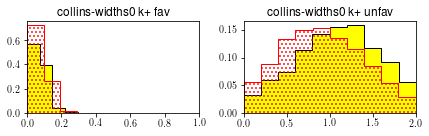

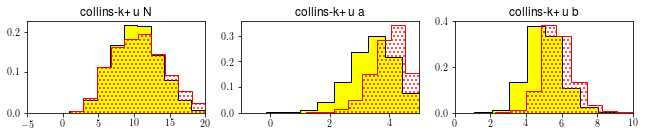

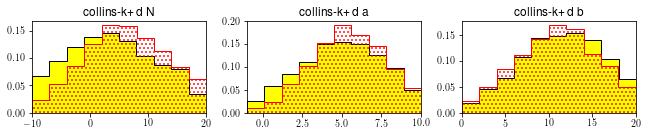

In [8]:
plot_params('collins',['widths0 k+ fav','widths0 k+ unfav'])
plot_params('collins',['k+ u N','k+ u a','k+ u b'])
plot_params('collins',['k+ d N','k+ d a','k+ d b'])

## PDFs and FFs

In [9]:
def calc(run,func,msg):
    RAW=[]
    bar=BAR(msg,len(run.samples))
    for i in range(len(run.samples)):
        par=run.samples[i]
        run.parman.set_new_params(par)
        RAW.append(func())
        bar.next()
    bar.finish()
    RAW=np.array(RAW)
    f =np.einsum('k,kif->if',run.weights,RAW)
    df=np.einsum('k,kif->if',run.weights,(RAW-f)**2)**0.5
    f=np.einsum('if->fi',f)
    df=np.einsum('if->fi',df)
    return {'f':f,'df':df}

## Transversity

In [10]:
X1=10**np.linspace(-3,-1)
X2=np.linspace(0.101,0.999)
X=np.append(X1,X2)
h1=calc(run1,lambda : [run1.resman.conf['transversity'].get_C(x,1) for x in X],'calc h1')
h2=calc(run2,lambda : [run2.resman.conf['transversity'].get_C(x,1) for x in X],'calc h2')

calc h1 [100%]
calc h2 [100%]


In [11]:
Z1=10**np.linspace(-3,-1)
Z2=np.linspace(0.101,0.999)
Z=np.append(Z1,Z2)
Hpi1=calc(run1,lambda : [run1.resman.conf['collins'].get_C(z,1,'pi+') for z in Z],'calc H(pi+)')
Hpi2=calc(run2,lambda : [run2.resman.conf['collins'].get_C(z,1,'pi+') for z in Z],'calc H(pi+)')
Hk1=calc(run1,lambda : [run1.resman.conf['collins'].get_C(z,1,'k+') for z in Z],'calc H(k+)')
Hk2=calc(run2,lambda : [run2.resman.conf['collins'].get_C(z,1,'k+') for z in Z],'calc H(k+)')

calc H(pi+) [100%]
calc H(pi+) [100%]
calc H(k+) [100%]
calc H(k+) [100%]


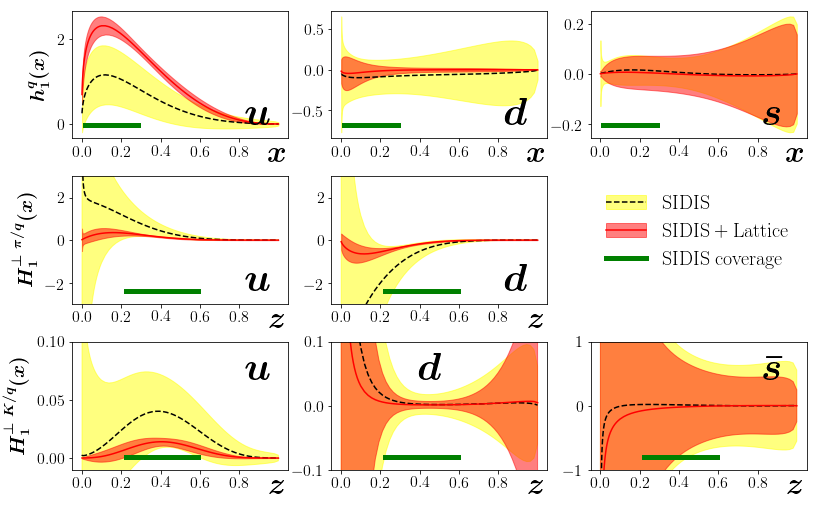

In [12]:
nrows,ncols=3,3
py.figure(figsize=(ncols*4,nrows*2.5))

def plot(idx,flav,legend=False,ylims=None):
    ax=py.subplot(nrows,ncols,idx)
    band1=ax.fill_between(X,(h1['f'][flav]-h1['df'][flav]),(h1['f'][flav]+h1['df'][flav]),color='Yellow',alpha=0.5)
    line1,=ax.plot(X,h1['f'][flav],'k--')
    band2=ax.fill_between(X,(h2['f'][flav]-h2['df'][flav]),(h2['f'][flav]+h2['df'][flav]),color='r',alpha=0.5)
    line2,=ax.plot(X,h2['f'][flav],'r-')
    if ylims!=None: ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlabel(r'$\boldsymbol{x}$',size=30)
    ax.xaxis.set_label_coords(0.95, -0.02)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([0,.2,.4,.6,.8])
    xmin=np.amin(kin['X'])
    xmax=np.amax(kin['X'])
    ymin, ymax = ax.get_ylim()
    dy=0.1*(ymax-ymin)
    ax.plot([xmin,xmax],[ymin+dy,ymin+dy],'g-',lw=5)
    return ax
 
def plotpi(idx,flav,ylims=None):
    ax=py.subplot(nrows,ncols,idx)
    band1=ax.fill_between(Z,(Hpi1['f'][flav]-Hpi1['df'][flav]),(Hpi1['f'][flav]+Hpi1['df'][flav]),color='Yellow',alpha=0.5)
    line1,=ax.plot(Z,Hpi1['f'][flav],'k--')
    band2=ax.fill_between(Z,(Hpi2['f'][flav]-Hpi2['df'][flav]),(Hpi2['f'][flav]+Hpi2['df'][flav]),color='r',alpha=0.5)
    line2,=ax.plot(Z,Hpi2['f'][flav],'r-')
    if ylims!=None: ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlabel(r'$\boldsymbol{z}$',size=30)
    ax.xaxis.set_label_coords(0.95, -0.02)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([0,.2,.4,.6,.8])
    zmin=np.amin(kin['Z'])
    zmax=np.amax(kin['Z'])
    ymin, ymax = ax.get_ylim()
    dy=0.1*(ymax-ymin)
    line,=ax.plot([zmin,zmax],[ymin+dy,ymin+dy],'g-',lw=5)
    return ax,(band1,line1),(band2,line2),line

def plotk(idx,flav,ylims=None):
    ax=py.subplot(nrows,ncols,idx)
    band1=ax.fill_between(Z,(Hk1['f'][flav]-Hk1['df'][flav]),(Hk1['f'][flav]+Hk1['df'][flav]),color='Yellow',alpha=0.5)
    line1,=ax.plot(Z,Hk1['f'][flav],'k--')
    band2=ax.fill_between(Z,(Hk2['f'][flav]-Hk2['df'][flav]),(Hk2['f'][flav]+Hk2['df'][flav]),color='r',alpha=0.5)
    line2,=ax.plot(Z,Hk2['f'][flav],'r-')
    if ylims!=None: ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlabel(r'$\boldsymbol{z}$',size=30)
    ax.xaxis.set_label_coords(0.95, -0.02)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([0,.2,.4,.6,.8])
    zmin=np.amin(kin['Z'])
    zmax=np.amax(kin['Z'])
    ymin, ymax = ax.get_ylim()
    dy=0.1*(ymax-ymin)
    line,=ax.plot([zmin,zmax],[ymin+dy,ymin+dy],'g-',lw=5)
    return ax

ax=plot(1,1)
ax.set_ylabel(r'$\boldsymbol{h_1^q(x)}$',size=20)
ax.text(0.8,0.1,r'$\boldsymbol{u}$',size=40,transform=ax.transAxes)

ax=plot(2,3)
ax.text(0.8,0.1,r'$\boldsymbol{d}$',size=40,transform=ax.transAxes)

ax=plot(3,5)
ax.text(0.8,0.1,r'$\boldsymbol{s}$',size=40,transform=ax.transAxes)

ax,b1,b2,l=plotpi(4,1,[-3,3])
ax.set_ylabel(r'$\boldsymbol{H_1^{\perp~\pi/q}(x)}$',size=20)
ax.text(0.8,0.1,r'$\boldsymbol{u}$',size=40,transform=ax.transAxes)

ax,b1,b2,l=plotpi(5,3,[-3,3])
ax.legend([b1,b2,l],[r'$\rm SIDIS$',r'$\rm SIDIS+Lattice$',r'$\rm SIDIS~coverage$']\
    ,fontsize=20,frameon=False,loc=1,bbox_to_anchor=(2.2, 1))
ax.text(0.8,0.1,r'$\boldsymbol{d}$',size=40,transform=ax.transAxes)

ax=plotk(7,1,[-0.01,0.1])
ax.set_ylabel(r'$\boldsymbol{H_1^{\perp~K/q}(x)}$',size=20)
ax.text(0.8,0.7,r'$\boldsymbol{u}$',size=40,transform=ax.transAxes)

ax=plotk(8,3,[-0.1,0.1])
ax.text(0.4,0.7,r'$\boldsymbol{d}$',size=40,transform=ax.transAxes)

ax=plotk(9,6,[-1,1])
ax.text(0.8,0.7,r'$\boldsymbol{\bar{s}}$',size=40,transform=ax.transAxes)

py.subplots_adjust(wspace=0.2, hspace=0.3,left=0.1, bottom=0.1, right=0.95, top=0.95)
#py.tight_layout()
py.savefig('gallery/transversity-collins.pdf')

## gT

In [13]:
def calc2(run,func,msg):
    RAW=[]
    bar=BAR(msg,len(run.samples))
    for i in range(len(run.samples)):
        par=run.samples[i]
        run.parman.set_new_params(par)
        RAW.append(func())
        bar.next()
    bar.finish()
    RAW=np.array(RAW)
    return RAW

gT1=calc2(run1,lambda : run1.moments.get_gT(),'calc gT1')
gT2=calc2(run2,lambda : run2.moments.get_gT(),'calc gT2')

calc gT1 [100%]
calc gT2 [100%]


gT1=       0.5 +/-        0.4
gT2=      1.00 +/-       0.04


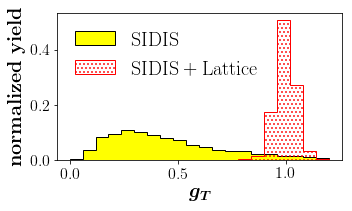

In [95]:
nrows,ncols=1,1
py.figure(figsize=(ncols*5,nrows*3))

ax=py.subplot(nrows,ncols,1)
R=(0,1.2)
ax.hist(gT1,histtype='stepfilled',range=R\
    ,weights=run1.weights,bins=20\
    ,facecolor='Yellow',edgecolor='k'
    ,label=r'$\rm SIDIS$')
ax.hist(gT2,histtype='stepfilled',range=R\
    ,weights=run2.weights,bins=20,facecolor='none',edgecolor='r',hatch='...'\
    ,label=r'$\rm SIDIS+Lattice$')
ax.set_ylabel(r'$\boldsymbol{\rm normalized~yield}$',size=20)
ax.set_xlabel(r'$\boldsymbol{g_T}$',size=20)
ax.tick_params(axis='both', which='major', labelsize=16)
#ax.set_xticks([0,.2,.4,.6,.8,1])
ax.legend(frameon=False,fontsize=20,loc=2)
py.tight_layout()
py.savefig('gallery/gT.pdf')

EgT1 = np.einsum('k,k',gT1,run1.weights)
SgT1 = np.einsum('k,k',(gT1-EgT1)**2,run1.weights)**0.5
EgT2 = np.einsum('k,k',gT2,run2.weights)
SgT2 = np.einsum('k,k',(gT2-EgT2)**2,run2.weights)**0.5

print 'gT1=%10.1f +/- %10.1f'%(EgT1,SgT1)
print 'gT2=%10.2f +/- %10.2f'%(EgT2,SgT2)

## Data vs Theory

In [83]:
RAW1=load('outputs/transversity/raw')
RAW2=load('outputs/transversity2/raw')

In [89]:
def process_raw(run,RAW):
    RES=RAW['RES']
    THY=RAW['THY']
    for k in RES:
        if k=='sidis': 
            for kk in RES[k]: 
                thy =np.einsum('k,ki',run.weights,np.array(THY[k][kk]))
                dthy=np.einsum('k,ki',run.weights,(np.array(THY[k][kk])-thy)**2)**0.5
                residuals=np.einsum('k,ki',run.weights,RES[k][kk])
                run.resman.sidisres.tabs[kk]['thy']=thy
                run.resman.sidisres.tabs[kk]['dthy']=dthy
                run.resman.sidisres.tabs[kk]['residuals']=residuals
                run.resman.sidisres.tabs[kk]['chi2']=residuals**2
                run.resman.sidisres.tabs[kk]=pd.DataFrame(run.resman.sidisres.tabs[kk])
        if k=='moments':
            for kk in RES[k]: 
                thy =np.einsum('k,ki',run.weights,np.array(THY[k][kk]))
                dthy=np.einsum('k,ki',run.weights,(np.array(THY[k][kk])-thy)**2)**0.5
                residuals=np.einsum('k,ki',run.weights,RES[k][kk])
                run.resman.momres.tabs[kk]['thy']=thy
                run.resman.momres.tabs[kk]['dthy']=dthy
                run.resman.momres.tabs[kk]['residuals']=residuals
                run.resman.momres.tabs[kk]['chi2']=residuals**2
                run.resman.momres.tabs[kk]=pd.DataFrame(run.resman.momres.tabs[kk])

In [90]:
process_raw(run1,RAW1)
process_raw(run2,RAW2)

In [46]:
RES1=RAW1['RES']
RES2=RAW2['RES']
NPTS=0
CHI21=0
CHI22=0
for k in RES1:
    for kk in RES1[k]:
        if k=='sidis':
            npts=run1.resman.sidisres.tabs[kk]['value'].size
            chi21=np.sum(run1.resman.sidisres.tabs[kk]['chi2'])
            chi22=np.sum(run2.resman.sidisres.tabs[kk]['chi2'])
            NPTS+=npts
            CHI21+=chi21
            CHI22+=chi22
            had=run1.resman.sidisres.tabs[kk]['hadron'].values[0]
            tar=run1.resman.sidisres.tabs[kk]['target'].values[0]
            dep=run1.resman.sidisres.tabs[kk]['dependence'].values[0]
            col=run1.resman.sidisres.tabs[kk]['col'].values[0].upper().strip()
            if tar=='deuteron': tar='$d$'
            if tar=='proton':   tar='$p$'
            if had=='pi+': had='$\pi^+$'
            if had=='pi-': had='$\pi^-$'
            if had=='k+': had='$K^+$'
            if had=='k-': had='$K^-$'
            if dep=='x': dep='$x$'
            if dep=='z': dep='$z$'
            if dep.upper()=='PT': dep='$p_{T}$'
            msg=r'%10s \cite{} &%5s &%10s &%10s &%5d &%10.1f &%10.1f &%10.1f\\'
            print msg%(col,tar,had,dep,npts,chi21,chi22, chi22-chi21)
print '%d %10.1f %10.1f %10.1f'%(NPTS,CHI21,CHI22,CHI22-CHI21)

   COMPASS \cite{} &  $d$ &   $\pi^+$ &       $x$ &    6 &       8.9 &       9.3 &       0.4\\
   COMPASS \cite{} &  $d$ &   $\pi^+$ &   $p_{T}$ &    6 &       3.5 &       3.6 &       0.0\\
   COMPASS \cite{} &  $d$ &   $\pi^+$ &       $z$ &    6 &       5.0 &       5.3 &       0.3\\
   COMPASS \cite{} &  $d$ &   $\pi^-$ &       $x$ &    6 &       5.1 &       5.6 &       0.5\\
   COMPASS \cite{} &  $d$ &   $\pi^-$ &   $p_{T}$ &    6 &       6.1 &       6.0 &      -0.1\\
   COMPASS \cite{} &  $d$ &   $\pi^-$ &       $z$ &    6 &       5.7 &       5.9 &       0.2\\
   COMPASS \cite{} &  $d$ &     $K^+$ &       $x$ &    7 &       5.2 &       5.1 &      -0.2\\
   COMPASS \cite{} &  $d$ &     $K^+$ &   $p_{T}$ &    6 &       4.6 &       4.7 &       0.1\\
   COMPASS \cite{} &  $d$ &     $K^+$ &       $z$ &    6 &       0.8 &       0.8 &       0.0\\
   COMPASS \cite{} &  $d$ &     $K^-$ &       $x$ &    7 &      10.1 &      10.2 &       0.1\\
   COMPASS \cite{} &  $d$ &     $K^-$ &   $p_{T}$ 

## x dependence

In [18]:
def get_key(K,tar,had,col,tabs,dep):
    kk=None
    for k in K:
        d=tabs[k]
        #print '-->',d['target'].values[0],d['hadron'].values[0],d['col'].values[0].upper()
        if tar==d['target'].values[0] \
            and had==d['hadron'].values[0] \
            and dep==d['dependence'].values[0] \
            and col==d['col'].values[0].upper().strip(): kk=k
    return kk

In [19]:
tabs=run1.resman.sidisres.tabs
def plot(idx,dep,tar,had,col,legend=False):
    #print tar,had,col
    k=get_key(tabs.keys(),tar,had,col,tabs,dep)
    d1=run1.resman.sidisres.tabs[k]
    d2=run2.resman.sidisres.tabs[k]
    ax=py.subplot(nrows,ncols,idx)
    dep=d1['dependence'].values[0]
    #obs=d['obs'].values[0]
    tar=d1['target'].values[0]
    had=d1['hadron'].values[0]
    if dep=='pt': dep='pT'
    sign=1
    if col=='COMPASS': sign=-1
    shift=0
    if '-' in had:shift=0.005
    if '-' in had: e=ax.errorbar(d1[dep]+shift,sign*d1['value'],d1['alpha'],fmt='kv')
    if '+' in had: e=ax.errorbar(d1[dep]+shift,sign*d1['value'],d1['alpha'],fmt='k^')
    b1=ax.fill_between(d1[dep],sign*(d1['thy']-d1['dthy']),sign*(d1['thy']+d1['dthy']),color='Yellow',alpha=0.5)
    b2=ax.fill_between(d2[dep],sign*(d2['thy']-d2['dthy']),sign*(d2['thy']+d2['dthy']),facecolor='none',alpha=0.5,edgecolor='r',hatch='...')
    l1,=ax.plot(d1[dep],sign*d1['thy'],'k--')
    l2,=ax.plot(d2[dep],sign*d2['thy'],'r-')
    if dep=='x': ax.set_xlabel(r'$\boldsymbol{x}$',size=20)
    if dep=='z': ax.set_xlabel(r'$\boldsymbol{z}$',size=20)
    if dep=='pT': ax.set_xlabel(r'$\boldsymbol{p_T}$',size=20)
    ax.xaxis.set_label_coords(0.95, -0.02)
    if dep=='x':
        ax.set_xlim(0,0.3)
        ax.set_xticks([0.1,0.2])
    if dep=='z':
        ax.set_xlim(0.2,0.65)
        ax.set_xticks([0.3,0.4,0.5])
    if dep=='pT':
        ax.set_xlim(0.1,0.9)
        ax.set_xticks([0.2,0.4,0.6])

    #if dep=='pT':ax.set_xlim(0.2,0.65)
    #ax.tick_params(axis='both', which='major', labelsize=16)
    #ax.tick_params(axis='both', which='major', labelsize=20)
    #ax.set_ylabel(obs)
    #ax.set_title('%s %s %s'%(tar,had.replace('+','').replace('-',''),col))
    #ax.set_xlim(0,0.3)
    #ax.set_ylim(-.1,.1)
    #ax.set_xticklabels([])
    ax.text(0.1,0.1,col,transform=ax.transAxes,size=10)
    if legend: return ax,(b1,l1),(b2,l2),e
    else: return ax


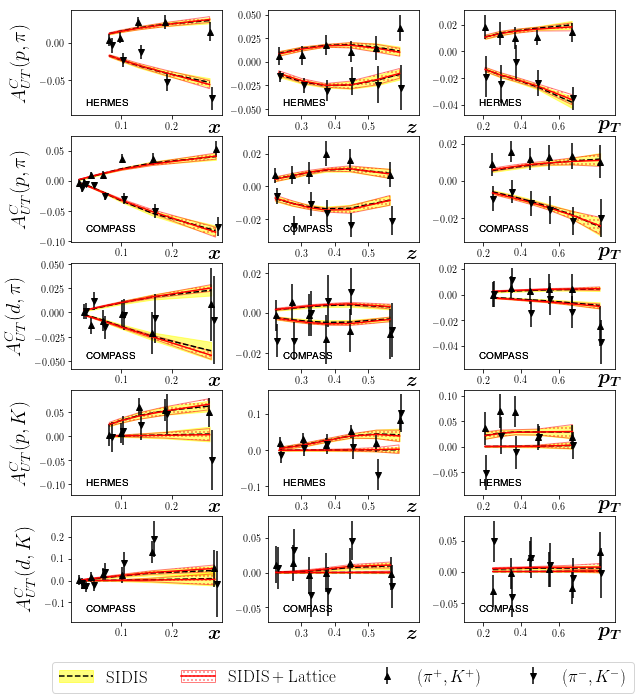

In [20]:
nrows,ncols=5,3
py.figure(figsize=(ncols*3,nrows*2))

ax=plot(1,'x','proton','pi+','HERMES')
ax=plot(1,'x','proton','pi-','HERMES')
ax.set_ylabel(r'$A_{UT}^{C}(p,\pi)$',size=20)
ax=plot(2,'z','proton','pi+','HERMES')
ax=plot(2,'z','proton','pi-','HERMES')
ax=plot(3,'pt','proton','pi+','HERMES')
ax=plot(3,'pt','proton','pi-','HERMES')

ax=plot(4,'x','proton','pi+','COMPASS')
ax=plot(4,'x','proton','pi-','COMPASS')
ax.set_ylabel(r'$A_{UT}^{C}(p,\pi)$',size=20)
ax=plot(5,'z','proton','pi+','COMPASS')
ax=plot(5,'z','proton','pi-','COMPASS')
ax=plot(6,'pt','proton','pi+','COMPASS')
ax=plot(6,'pt','proton','pi-','COMPASS')

ax=plot(7,'x','deuteron','pi+','COMPASS')
ax=plot(7,'x','deuteron','pi-','COMPASS')
ax.set_ylabel(r'$A_{UT}^{C}(d,\pi)$',size=20)
ax=plot(8,'z','deuteron','pi+','COMPASS')
ax=plot(8,'z','deuteron','pi-','COMPASS')
ax=plot(9,'pT','deuteron','pi+','COMPASS')
ax=plot(9,'pT','deuteron','pi-','COMPASS')

ax=plot(10,'x','proton','k+','HERMES')
ax=plot(10,'x','proton','k-','HERMES')
ax.set_ylabel(r'$A_{UT}^{C}(p,K)$',size=20)
ax=plot(11,'z','proton','k+','HERMES')
ax=plot(11,'z','proton','k-','HERMES')
ax=plot(12,'pt','proton','k+','HERMES')
ax=plot(12,'pt','proton','k-','HERMES')

ax=plot(13,'x','deuteron','k+','COMPASS')
ax=plot(13,'x','deuteron','k-','COMPASS')
ax.set_ylabel(r'$A_{UT}^{C}(d,K)$',size=20)
ax=plot(15,'pT','deuteron','k+','COMPASS')
ax=plot(15,'pT','deuteron','k-','COMPASS')
ax,b1,b2,ep=plot(14,'z','deuteron','k+','COMPASS',legend=True)
ax,b1,b2,em=plot(14,'z','deuteron','k-','COMPASS',legend=True)
ax.legend([b1,b2,ep,em],[r'$\rm SIDIS$',r'$\rm SIDIS+Lattice$',r'$(\pi^+,K^+)$',r'$(\pi^-,K^-)$']\
          ,loc='upper center', bbox_to_anchor=(0.5, -0.3)\
          ,fancybox=True, shadow=False, ncol=4,fontsize=17)

py.subplots_adjust(wspace=0.3, hspace=0.2,left=0.11, bottom=0.1, right=0.95, top=0.95)
py.savefig('gallery/dvt.pdf')